improt necessary libraries

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature, color
import cv2
from tensorflow.keras.datasets import cifar10
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler

load image data and print it for cross checking

In [106]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

labels = ['airplane', 'deer', 'horse']
categories = [0, 4, 7]  # 0: airplane, 4: deer, 7: horse

# Create a mask for the training set
train_mask = np.isin(y_train, categories).flatten()
X_train_filtered = X_train[train_mask]
y_train_filtered = y_train[train_mask]

# Create a mask for the test set
test_mask = np.isin(y_test, categories).flatten()
X_test_filtered = X_test[test_mask]
y_test_filtered = y_test[test_mask]

print(f"Filtered X_train shape: {X_train_filtered.shape}")
print(f"Filtered y_train shape: {y_train_filtered.shape}")
print(f"Filtered X_test shape: {X_test_filtered.shape}")
print(f"Filtered y_test shape: {y_test_filtered.shape}")

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
Filtered X_train shape: (15000, 32, 32, 3)
Filtered y_train shape: (15000, 1)
Filtered X_test shape: (3000, 32, 32, 3)
Filtered y_test shape: (3000, 1)


plot the sample images

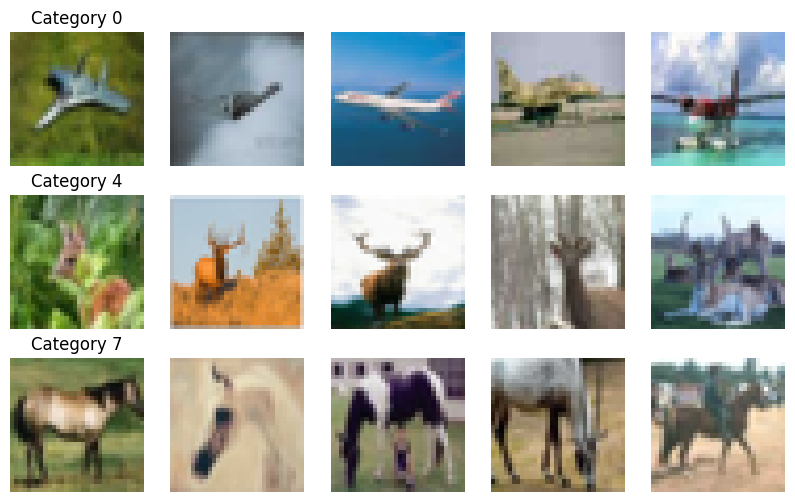

{0: array([10912, 12740, 11917,  5250,  3407]),
 4: array([10326, 11435,  8731, 13104,  2838]),
 7: array([9729, 7739, 6823, 8216, 8360])}

In [107]:
def plot_sample_images(data, labels, categories, num_samples=5):
    fig, axs = plt.subplots(len(categories), num_samples, figsize=(num_samples * 2, len(categories) * 2))
    sampled_indices = {}

    for idx, category in enumerate(categories):
        indices = np.where(labels == category)[0]
        random_indices = np.random.choice(indices, num_samples, replace=False)
        sampled_indices[category] = random_indices

        for j, image_index in enumerate(random_indices):
            ax = axs[idx, j] if len(categories) > 1 else axs[j]
            ax.imshow(data[image_index])
            ax.axis('off')
            if j == 0:
                ax.set_title(f"Category {category}")

    plt.show()
    return sampled_indices

plot_sample_images(X_train_filtered, y_train_filtered.flatten(), categories)

extract features bases on colour and spatial information feature. Use RGB colour values along with spatial coordinates (x, y) as features for each pixel. For enhancement, use texture features as well which is Local Binary Pattern (LBP) to capture texture.

In [108]:
def extract_features(image):
    h, w, c = image.shape
    features = np.zeros((h * w, 8))  # RGB + LBP + x + y

    # Convert image to grayscale
    gray_image = color.rgb2gray(image)

    # Calculate LBP features
    lbp = feature.local_binary_pattern(gray_image, P=8, R=1, method='uniform')

    for i in range(h):
        for j in range(w):
            features[i * w + j, 0:3] = image[i, j, :]
            features[i * w + j, 3] = lbp[i, j]
            features[i * w + j, 4] = i / h
            features[i * w + j, 5] = j / w

    return features

use spectral clustering

In [109]:
def apply_spectral_clustering(image, n_clusters=4):
    if image.ndim != 3:
        raise ValueError("The parameter `image` must be a 3-dimensional array (height, width, channels)")

    # Extract features
    features = extract_features(image)

    # Normalize the features
    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    # Apply Spectral Clustering
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', assign_labels='kmeans', random_state=42)
    labels = spectral.fit_predict(features)

    # Reshape labels back to the original image shape
    h, w, _ = image.shape
    segmented_image = labels.reshape(h, w)
    return segmented_image

deply images after multi feature extracted stpectral clustering

In [110]:
def deploy(original_images, segmented_images, categories, num_samples=5):
    fig, axs = plt.subplots(len(categories), num_samples * 2, figsize=(num_samples * 4, len(categories) * 2))

    for idx, category in enumerate(categories):
        for j in range(num_samples):
            original_ax = axs[idx, j * 2] if len(categories) > 1 else axs[j * 2]
            segmented_ax = axs[idx, j * 2 + 1] if len(categories) > 1 else axs[j * 2 + 1]

            original_ax.imshow(original_images[category][j])
            original_ax.set_title("Original Image")
            original_ax.axis('off')

            segmented_ax.imshow(segmented_images[category][j], cmap='viridis')
            segmented_ax.set_title("Segmented Image")
            segmented_ax.axis('off')

    plt.tight_layout()
    plt.show()

deply the images

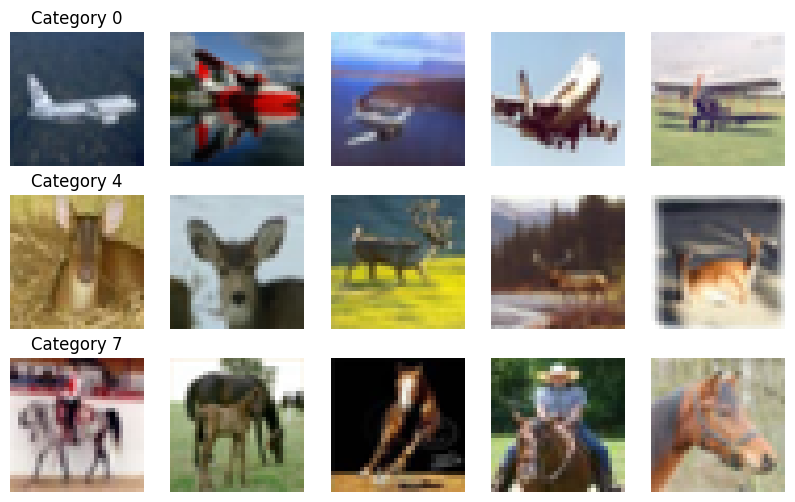

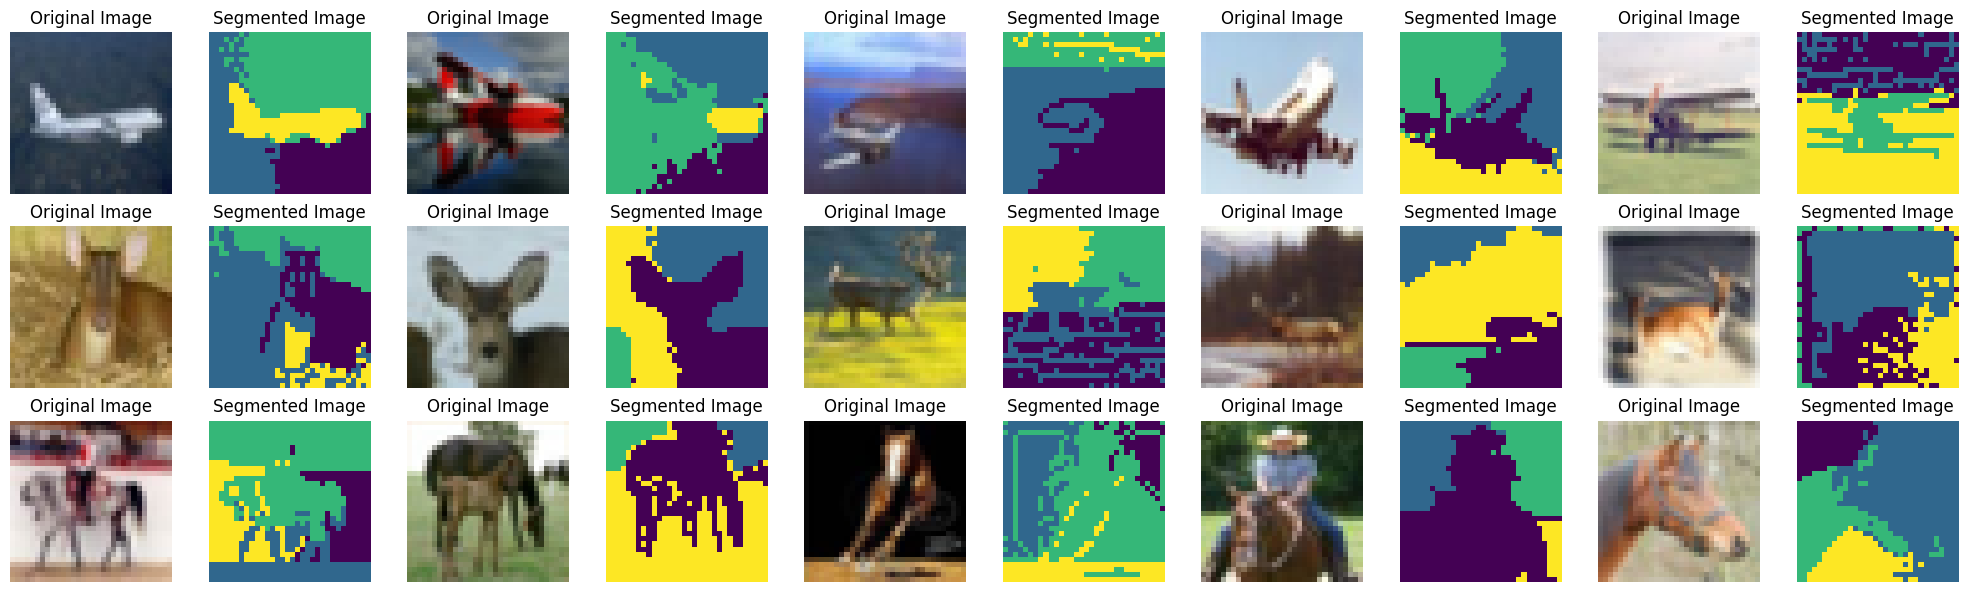

In [111]:
sampled_indices = plot_sample_images(X_train_filtered, y_train_filtered.flatten(), categories)

original_images = {category: [] for category in categories}
segmented_images = {category: [] for category in categories}

for category in categories:
    for image_index in sampled_indices[category]:
        sample_image = X_train_filtered[image_index]
        segmented_image = apply_spectral_clustering(sample_image)
        segmented_image_resized = cv2.resize(segmented_image, (sample_image.shape[1], sample_image.shape[0]), interpolation=cv2.INTER_NEAREST)

        original_images[category].append(sample_image)
        segmented_images[category].append(segmented_image_resized)

deploy(original_images, segmented_images, categories)